### Import packages

In [39]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [40]:
data = pd.read_csv("../input/winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [42]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [43]:
from sklearn.preprocessing import LabelEncoder

bins = (2, 6, 8)
group_names = ['bad', 'good']

data['quality'] = pd.cut(data["quality"], bins = bins, labels = group_names)

label_quality = LabelEncoder()

data['quality'] = label_quality.fit_transform(data['quality'].astype(str))
data['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

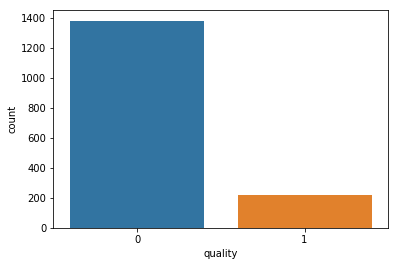

In [44]:
sns.countplot(data['quality'])
plt.show()

In [45]:
X = data.drop("quality", axis=1)
y = data["quality"]

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=10)

### Compare Models:

In [47]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [48]:
import warnings
warnings.filterwarnings("ignore")

In [49]:
# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(("RFC",RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.879069 (0.026925)
LDA: 0.872402 (0.030935)
KNN: 0.858200 (0.030806)
CART: 0.876576 (0.023157)
NB: 0.839825 (0.039623)
SVM: 0.868214 (0.023857)
RFC: 0.899069 (0.025188)


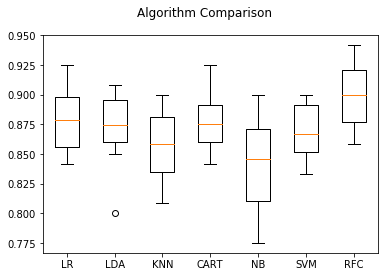

In [50]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Fine tuning the models:

**1. Logistic Regression**

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params_dict={'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2']}
clf_lr=GridSearchCV(estimator=LogisticRegression(),param_grid=params_dict,scoring='accuracy',cv=10)
clf_lr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [52]:
clf_lr.best_params_

{'C': 10, 'penalty': 'l2'}

In [53]:
clf_lr.best_score_ 

0.8874061718098415

In [54]:
pred=clf_lr.predict(X_test)
accuracy_score(pred,y_test)

0.875

**Evaluate a score by cross-validation**

In [55]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_lr, X_train, y_train,n_jobs=-1, cv=10)
scores

array([0.84297521, 0.85833333, 0.89166667, 0.88333333, 0.93333333,
       0.88333333, 0.88333333, 0.89166667, 0.88235294, 0.8907563 ])

In [56]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.84297521 0.85833333 0.89166667 0.88333333 0.93333333 0.88333333
 0.88333333 0.89166667 0.88235294 0.8907563 ]
Mean: 0.8841084450309049
Standard deviation: 0.02223223097281079


In [57]:
y_test.value_counts()

0    341
1     59
Name: quality, dtype: int64

In [58]:
from sklearn.metrics import confusion_matrix,  roc_auc_score
confusion_matrix(pred, y_test)

array([[330,  39],
       [ 11,  20]])

In [59]:
roc_auc_score(y_test, pred)

0.6533624931656644

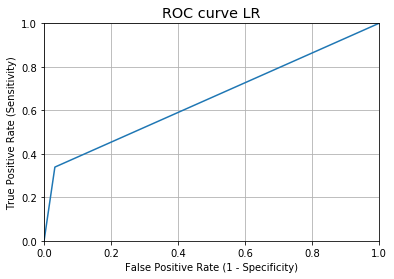

In [60]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve LR')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [61]:
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.6533624931656644


**Evaluate threshold**

![](http://cancerdiscovery.aacrjournals.org/content/candisc/3/2/148/F1.large.jpg?width=800&height=600&carousel=1)

In [62]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [63]:
evaluate_threshold(0.5)

Sensitivity: 0.3389830508474576
Specificity: 0.967741935483871


In [64]:
evaluate_threshold(.3)

Sensitivity: 0.3389830508474576
Specificity: 0.967741935483871


It seems like changing the threshold values does not implies any changes in sensitivity and specificity.

**Lets see cross_validation in AUC scores:**

In [65]:
# calculate cross-validated AUC
cross_val_score(clf_lr, X_train, y_train, cv=10, scoring='roc_auc').mean()

0.8533207417582418

Better than previous auc score(.65)

**2. SVM **

In [66]:
params_dict={'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10],'kernel':['linear','rbf']}
clf=GridSearchCV(estimator=SVC(),param_grid=params_dict,scoring='accuracy',cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
clf.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [68]:
clf.best_score_ 

0.8982485404503753

In [72]:
pred_svm=clf.predict(X_test)
accuracy_score(pred_svm,y_test)

0.88

In [76]:
confusion_matrix(pred_svm, y_test)

array([[337,  44],
       [  4,  15]])

In [77]:
roc_auc_score(y_test, pred_svm)

0.6212535414285004

In [80]:
# calculate cross-validated AUC
cross_val_score(clf, X_train, y_train, cv=4, scoring='roc_auc').mean()

0.771700467875037

In [81]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
display_scores(scores)

Scores: [0.89626556 0.9125     0.89166667 0.88702929 0.89539749]
Mean: 0.8965718010150638
Standard deviation: 0.008605814290414364


**3. Random Forest**

In [82]:
params_dict={'n_estimators':[500],'max_features':['auto','sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=params_dict,scoring='accuracy',cv=5)
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [83]:
clf_rf.best_params_

{'max_features': 'log2', 'n_estimators': 500}

In [84]:
clf_rf.best_score_ 

0.9115929941618015

In [85]:
pred_rf=clf_rf.predict(X_test)
accuracy_score(pred_rf,y_test)

0.905

In [86]:
confusion_matrix(pred_rf, y_test)

array([[336,  33],
       [  5,  26]])

In [87]:
roc_auc_score(y_test, pred_rf)

0.7130076047517272

In [88]:
cross_val_score(clf_rf, X_train, y_train, cv=4, scoring='roc_auc').mean()

0.9119310791165068

In [89]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=5)
display_scores(scores)

Scores: [0.8879668  0.90833333 0.925      0.88284519 0.91631799]
Mean: 0.9040926636457808
Standard deviation: 0.016223792184032495
